# Neural model of oddball task

#### Sugandha Sharma, August 30, 2017


<br>Through this notebook, you can explore the neural model of oddball task for a single subject. This notebook illustrates a step by step procedure of building and analysing the model. However, since its a single subject, you would not be able to see the overall trends in the response profiles. <br><br> You can find data for 100 subjects on Sherlock at: <br> /oak/stanford/groups/menon/projects/susharma/oddball/data_august29,2017. <br> <br> Alternatively you can also simulate new data by running the scripts which you can find at: <br> /oak/stanford/groups/menon/projects/susharma/oddball/scripts.

### Dependencies

Python 2.7.10
<br>Numpy 1.13.0
<br>Nengo 2.4.1
<br>Matplotlib 2.0.2
<br>Seaborn 0.8.0

## Step1: Setup the Environment

In [6]:
# import nengo and other nengo functions 
# required for building the model
import nengo
from nengo.dists import Choice
from nengo.dists import Uniform
from nengo.dists import Gaussian
from nengo.utils.compat import is_number
from nengo.utils.functions import piecewise
from nengo.utils.ensemble import tuning_curves

# import numpy for computations
import numpy as np

# import seaborn and matplotlib
# for plotting data
import seaborn as sns
sns.set_style(style='whitegrid')
sns.set_context("paper")

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
label_size = 21
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['legend.fontsize'] = 18


# setup for importing results (.png files)
path = '/oak/stanford/groups/menon/projects/susharma/oddball/results'
from IPython.display import Image

## Step2: Set Model Parameters and Stimulus Input

You can set the model parameters or change the input stimulus to the model as you wish by modifying them in the following block.

In [7]:
## Model Parameters

                     # synaptic time constants
tau_highpass = 0.5   # depressing synapse time constant - 0.5 refers to 0.5s or 500ms
recurrent_tau = 0.1  # recurrent synapse time constant for the parietal (evidence) ensemble
    
                     # weighted sum of sensory stimulus and accumulated evidence     
accum_wt = 0.70      # parameter weight on the accumulated evidence
sens_wt = 3.2        # parameter weight on the current sensory stimulus


## Stimulus Input Manipulations

std_intensity = 8    # intensity of the standard
dev_intensity = 4    # intensity of the deviant

prob_std = 0.8       # 80% standard
prob_dev = 0.2       # 20% deviant
                     # make sure the probabilities sum to 1

## Step3: Setup the Experiment

In [8]:
## Here I create a separate class that simulates the experiment.
## i.e., it simulates the stimulus inputs provided to the model

dev_trials = []
std_trials = []

isi = 600.0/1000.0            # inter-stimulus interval
stim_dur = 100.0/1000.0       # stimulus duration or presentation time
trial_len = isi + stim_dur    # length of each trial
prestimulus_baseline = 0.1    # 100 ms prestimulus baseline interval
remove_beg = int((trial_len - prestimulus_baseline) * 1000)  

class Experiment(object):
    def __init__(self, seed=None, isi=isi, stim_dur=stim_dur, std_value=std_intensity, dev_value=dev_intensity, 
                                                    trial_len=trial_len, prestim_baseline=prestimulus_baseline):
        self.rng = np.random.RandomState(seed=seed)
        self.prestim_baseline = prestim_baseline
        self.isi = isi
        self.stim_dur = stim_dur
        self.trial_len = trial_len
        self.std_value = std_value
        self.dev_value = dev_value
        self.prev_rise = 0
        self.stim_value = 0
        self.trial_number = 0   
    
    # provide stimulus for each trial and keep
    # track of deviant and standard trials
    def stimulus_in(self, t):         
        # pull up the value 
        if int(t*1000) % int(self.trial_len*1000) == 0:
            self.trial_number = self.trial_number+1    # increment the trial counter
            self.prev_rise = t
            self.stim_value = np.random.choice((self.std_value, self.dev_value), p=(prob_std, prob_dev))                          
            if self.stim_value == self.dev_value:
                dev_trials.append(self.trial_number)    # store the trial numbers of oddballs
            elif self.stim_value == self.std_value:
                std_trials.append(self.trial_number)
        # pull down the value - bring it back to 0
        elif int(t*1000) == (int (self.prev_rise*1000) + self.stim_dur*1000):
            self.stim_value = 0
        return self.stim_value
    

## Step4: Build the Nengo Model

Following is the schematic diagram of the neural model which is implemented in this notebook. Note that the delay circuit has been omitted for simplicity, since it doesn't affect the response profiles of the $\textit{sensory}$ and $\textit{parietal}$ ensembles.

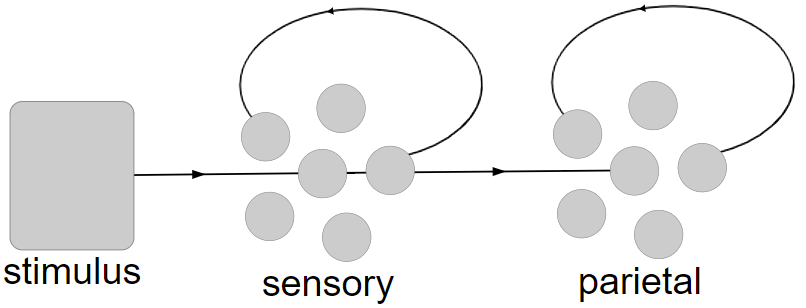

In [3]:
Image(filename= path + '/model_schematic.PNG')

### Depressing Synapse

Depressing synapse is implemented using Principle3 of the NEF (principle of Dynamics).

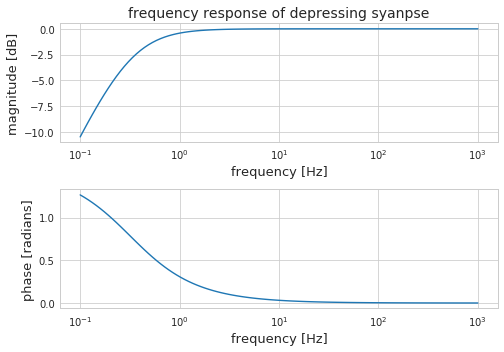

In [9]:
## depressing synapse
def highpass(tau, order=1):
    """Differentiated lowpass, raised to a given power."""
    if order < 1 or not is_number(order):
        raise ValueError("order (%s) must be integer >= 1" % order)
    num, den = map(np.poly1d, ([tau, 0], [tau, 1]))
    return nengo.LinearFilter(num**order, den**order)


synapse = nengo.synapses.LinearFilter([tau_highpass, 0], [tau_highpass, 1])
f = np.logspace(-1, 3, 100)
y = synapse.evaluate(f)


mpl.rcParams['xtick.labelsize'] = 10 
mpl.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(7,5))
plt.subplot(211) 
plt.semilogx(f, 20*np.log10(np.abs(y)))
plt.xlabel('frequency [Hz]', fontsize=13) 
plt.ylabel('magnitude [dB]', fontsize=13)
plt.title('frequency response of depressing syanpse', fontsize=14)

plt.subplot(212) 
plt.semilogx(f, np.angle(y))
plt.xlabel('frequency [Hz]', fontsize=13)
plt.ylabel('phase [radians]', fontsize=13)
plt.tight_layout()
plt.show()

### Neural Model

In [20]:
dev_trials = []
std_trials = []


## nengo model
seed = 34564 
model = nengo.Network(seed=seed)
model.config[nengo.Ensemble].neuron_type=nengo.LIFRate() 
model.config[nengo.Ensemble].max_rates=Uniform(20,120)
model.config[nengo.Ensemble].radius=10
with model:
    
    # get input from the experimental setup through a nengo node
    exp = Experiment(seed=seed)
    stimulus = nengo.Node(exp.stimulus_in)
  
    # create the ensemble with added noise at the input of each neuron
    sensory = nengo.Ensemble(200, dimensions=1, noise=nengo.processes.BrownNoise(Gaussian(0,1), seed=seed))
    nengo.Connection(stimulus, sensory, synapse=highpass(tau_highpass)) #, transform=-1) 
    nengo.Connection(sensory, sensory, synapse=0.01)   # recurrent connection on sensory ensemble
    
    # create a 2-dimensional ensemble
    parietal = nengo.Ensemble(n_neurons=1000, dimensions=2)
    
    # function to be computed on the recurrent 
    # connection of the parietal ensemble
    def response(x):
        sensory, accum = x
        accum = (sens_wt*sensory+accum_wt*accum)*1.0
        return 0, accum
    
    
    # add recurrent connection on the parietal ensemble
    nengo.Connection(parietal, parietal, synapse=recurrent_tau, function=response)      
    nengo.Connection(sensory, parietal[0], synapse=0.01) #, transform=-1)   
    
    # add probes to collect data from the simulation
    stim_p = nengo.Probe(stimulus, synapse=None)
    sensory_p = nengo.Probe(sensory, synapse=0.01)
    parietal0_p = nengo.Probe(parietal[0], synapse=0.01)
    parietal1_p = nengo.Probe(parietal[1], synapse=0.01)
    
    
sim = nengo.Simulator(model)   # create a simulator object
sim.run(120)                   # run the simulation for 120 seconds ~ 170 trials

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:36.                                                 


### Tuning Curves of Sensory Ensemble

The $\textit{sensory}$ ensemble is a 1 dimensional ensemble which responds to stimulus x. In this case, x refers to the intensity of the sensory stimulus that the $\textit{sensory}$ ensemble receives as input.

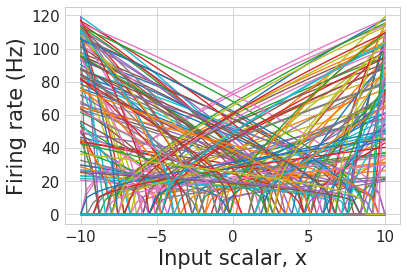

In [26]:
# plot ensemble tuning curves
mpl.rcParams['xtick.labelsize'] = 15 
mpl.rcParams['ytick.labelsize'] = 15
with sim:
    plt.figure()
    plt.plot(*tuning_curves(sensory, sim))
    plt.ylabel("Firing rate (Hz)")
    plt.xlabel("Input scalar, x")

### Tuning Curves of Parietal Ensemble
The $\textit{parietal}$ ensemble is a 2 dimensional ensemble and its two dimensions correspond to stimuli x1 and x2. In this case, x1 is the current sensory stimulus and x2 is the accumulated sensory evidence.

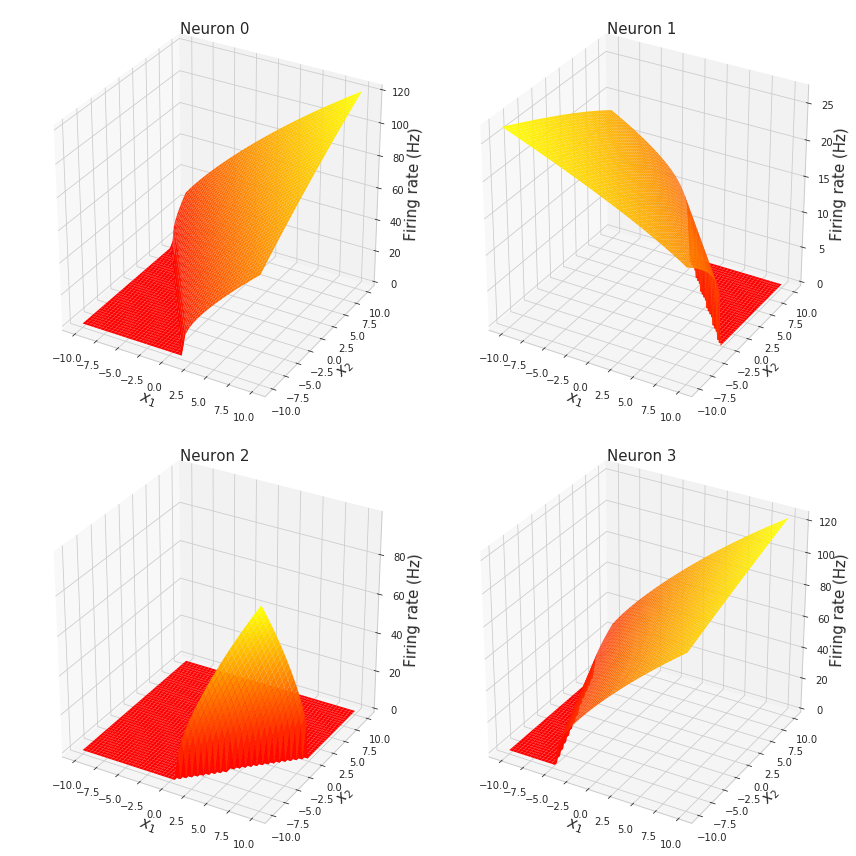

In [27]:
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['xtick.labelsize'] = 10 
mpl.rcParams['ytick.labelsize'] = 10
with sim:
    eval_points, activities = tuning_curves(parietal, sim)
    
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection='3d')
ax.set_title("Tuning curve of all neurons")
for i in range(4):
    ax = plt.subplot(2 ,2, i+1, projection='3d')
    ax.set_title("Neuron %d" % i, fontsize=15)
    ax.plot_surface(
        eval_points.T[0],
        eval_points.T[1],
        activities.T[i+25],
        cmap=plt.cm.autumn)
    ax.set_xlabel("$x_1$", fontsize=15)
    ax.set_ylabel("$x_2$", fontsize=15)
    ax.set_zlabel("Firing rate (Hz)", fontsize=15) 
plt.tight_layout()    
plt.show()

## Step5: Post Processing

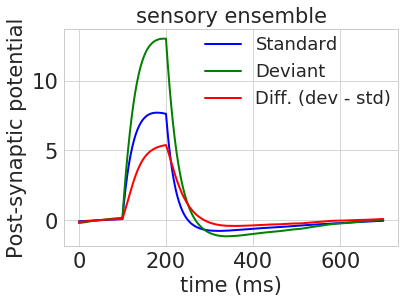

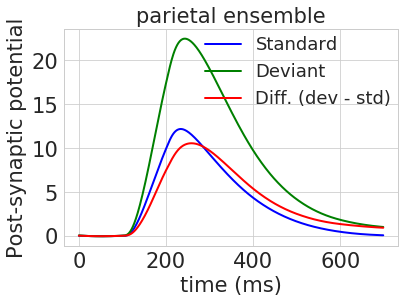

In [21]:
# Post Processing to get P300
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size
def analyse(probe, title):
    data = sim.data[probe]
    data = data[remove_beg:]   # remove the first trial

    num_trials = int(np.floor(len(data) / float(trial_len*1000)))
    trial_data = data[:num_trials*int(trial_len*1000)]
    
    # remove the first and the last (unfinished trial)
    for x in dev_trials:
        if x>num_trials or x == 1:
            dev_trials.remove(x)

    for y in std_trials:        
        if y>num_trials or x == 1:
            std_trials.remove(y)

    trial_data = trial_data.reshape(num_trials, int(trial_len*1000))
    dev_data = trial_data[np.where(dev_trials)]    # get the deviant trials
    std_data = trial_data[np.where(std_trials)]    # get the standard trials
    
    # subtract the baseline from trials
    # baseline is computed by subtracting the avg value during first 100ms
    baseline = int(prestimulus_baseline*1000-1)
    dev_data =  [trial - np.mean(trial[0:baseline]) for trial in dev_data]    
    std_data =  [trial - np.mean(trial[0:baseline]) for trial in std_data]

    # compute the avg of all the deviant and standard trials
    avg_dev_data = np.average(dev_data, axis=0)   
    avg_std_data = np.average(std_data, axis=0)
    diff = avg_dev_data-avg_std_data

    # plot the results
    plt.figure()
    plt.title(title)
    plt.plot(range(int(trial_len*1000)), avg_std_data, 'b', label="Standard", linewidth=2)
    plt.plot(range(int(trial_len*1000)), avg_dev_data, 'g', label="Deviant", linewidth=2)
    plt.plot(range(int(trial_len*1000)), diff, 'r', label="Diff. (dev - std)", linewidth=2)
    plt.ylabel("Post-synaptic potential")
    plt.xlabel("time (ms)")
    plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., fontsize=18)
    plt.show()    
    return std_data, dev_data
    

# analyse (post-process) the response of sensory and parietal ensembles
sens_std_data, sens_dev_data = analyse(sensory_p, "sensory ensemble") 
par_std_data, par_dev_data = analyse(parietal1_p, "parietal ensemble")

The plots above show the response profiles of $\textit{sensory}$ and $\textit{parietal}$ ensembles. You will these response profiles change as you change the parameter values in Step2. For example, on setting the prob_std and prob_dev to 0.5 each, the red curves which correspond to the difference between response to standards and deviants should flatten out.

## Visualizing single trials

Here I plot the single trials to see how response depression progresses through trials for both standards and deviants.

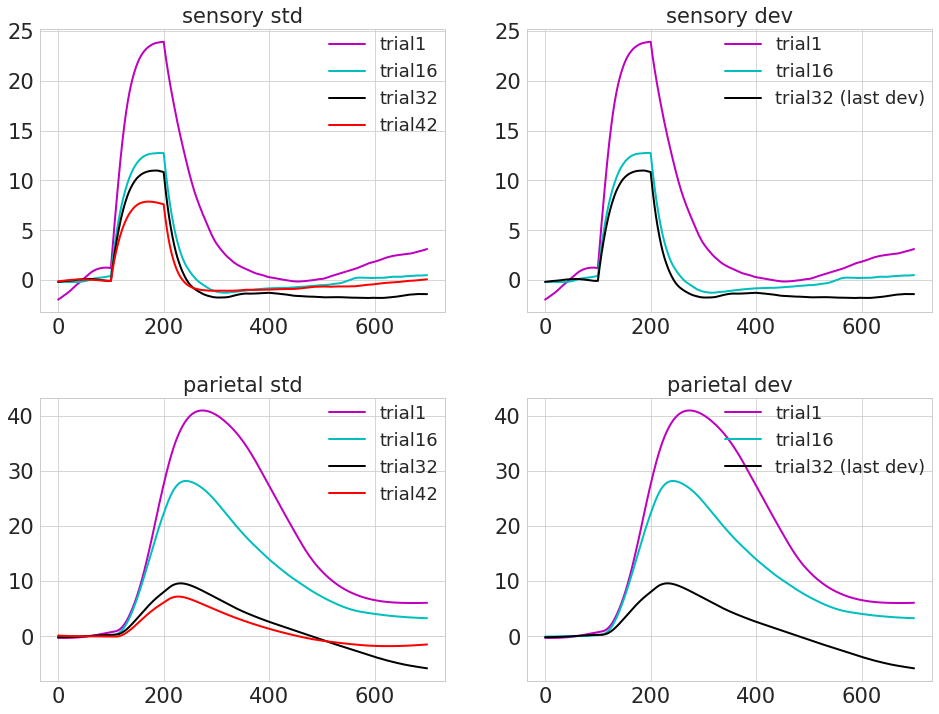

In [22]:
x = np.arange(700)

# find the number of std and dev trials
num_std_trials = len(sens_std_data)
num_dev_trials = len(sens_dev_data)

#print num_std_trials
#print num_dev_trials

s_std = np.asarray(sens_std_data)
s_dev = np.asarray(sens_dev_data)

p_std = np.asarray(par_std_data)
p_dev = np.asarray(par_dev_data)

# plot the standard and deviant trials for
# both the sensory and the parietal ensemble
f, axarr = plt.subplots(2, 2, figsize=(16,12))
axarr[0, 0].plot(x, s_std[0], 'm', label="trial1", linewidth=2)
axarr[0, 0].plot(x, s_std[num_dev_trials/2], 'c', label="trial" + str(num_dev_trials/2), linewidth=2)
axarr[0, 0].plot(x, s_std[num_dev_trials-1], 'k', label="trial" + str(num_dev_trials), linewidth=2)
axarr[0, 0].plot(x, s_std[num_dev_trials+10], 'r', label="trial"+str(num_dev_trials+10), linewidth=2)
axarr[0, 0].set_title('sensory std')
axarr[0, 0].legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., fontsize=18)

axarr[0, 1].plot(x, s_dev[0], 'm', label="trial1", linewidth=2)
axarr[0, 1].plot(x, s_dev[num_dev_trials/2], 'c', label="trial" + str(num_dev_trials/2), linewidth=2)
axarr[0, 1].plot(x, s_dev[num_dev_trials-1], 'k', label="trial" + str(num_dev_trials) + " (last dev)", linewidth=2)
axarr[0, 1].set_title('sensory dev')
axarr[0, 1].legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., fontsize=18)

axarr[1, 0].plot(x, p_std[0], 'm', label="trial1", linewidth=2)
axarr[1, 0].plot(x, p_std[num_dev_trials/2], 'c', label="trial" + str(num_dev_trials/2), linewidth=2)
axarr[1, 0].plot(x, p_std[num_dev_trials-1], 'k', label="trial" + str(num_dev_trials), linewidth=2)
axarr[1, 0].plot(x, p_std[num_dev_trials+10], 'r', label="trial"+str(num_dev_trials+10), linewidth=2)
axarr[1, 0].set_title('parietal std')
axarr[1, 0].legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., fontsize=18)

axarr[1, 1].plot(x, p_dev[0], 'm', label="trial1", linewidth=2)
axarr[1, 1].plot(x, p_dev[num_dev_trials/2], 'c', label="trial" + str(num_dev_trials/2), linewidth=2)
axarr[1, 1].plot(x, p_dev[num_dev_trials-1], 'k', label="trial" + str(num_dev_trials) + " (last dev)", linewidth=2)
axarr[1, 1].set_title('parietal dev')
axarr[1, 1].legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., fontsize=18)

f.subplots_adjust(hspace=0.3)


The above plots show that the responses of the standard and deviant stimuli get almost equally depressed if we compare them based on trial numbers. For example, the response to the first standard is the same as the response to the first deviant, response to 20th standard is the same as the response to the 20th deviant and so on. However, since there are fewer deviants, the response depression for the last deviant is relatively less than that of the last standard. This causes the average response to the deviants to be much lower than the average response to the standards.

## Analysis and Results
This section shows the results obtained from the model after analysing the data from 100 subjects. The graphs show mean responses with 95% confidence intervals. Note that for these results, the transforms were set to -1 at two places indicated in the Neural Model code block, hence the response of the sensory ensemble is negative. However this doesn't make any difference to the general trends shown in the response profiles.

### Probability results

When the standard and deviant have the same probability (50% Dev), no MMN/P300 like signal is generated. However, as the probability of the deviant is decreased, the MMN/P300 increases. The overall trend of amplitude variation as the probability of the deviant is decreased shows that the peak amplitude of both MMN and P300 increases as the probability of deviant is decreased (and that of standard is increased). This is because a low probability makes the deviant rare and thus prevents adaptation of the deviant.

Sensory Ensemble Response


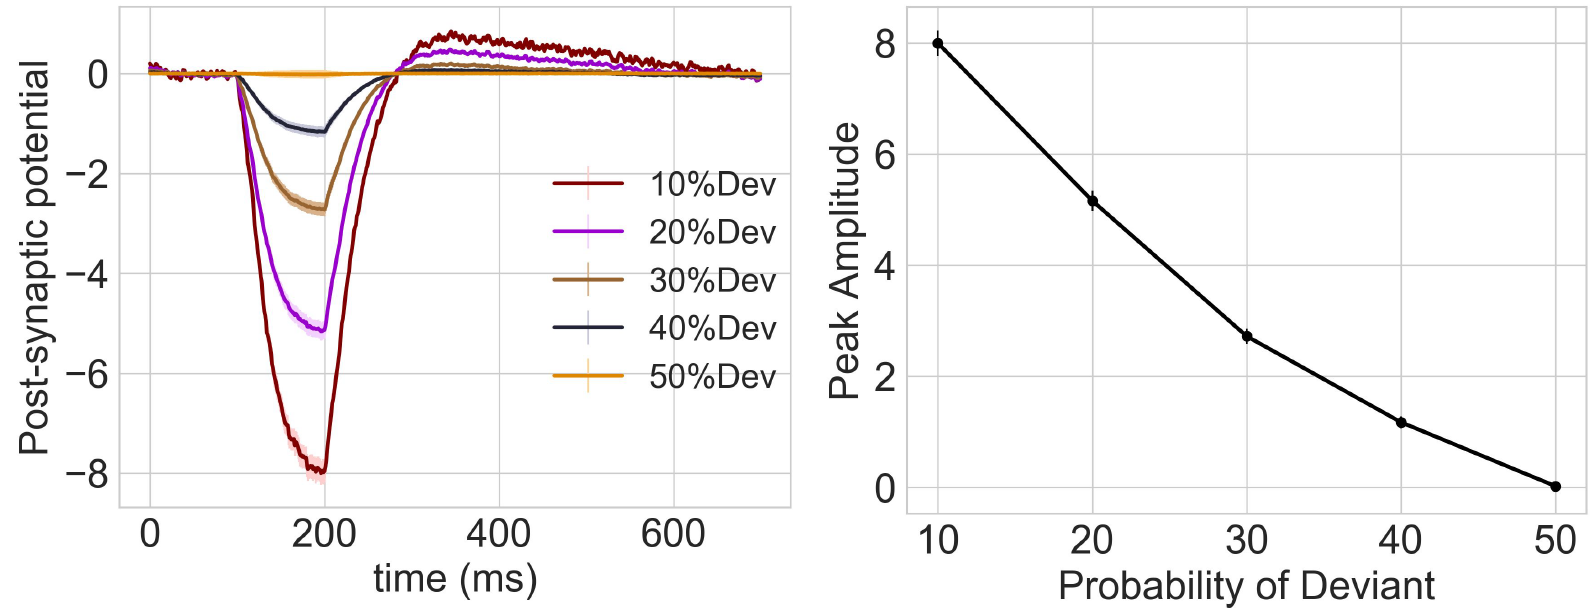

In [51]:
print "Sensory Ensemble Response"
Image(filename= path + '/probability_sensory.PNG', width=900, height=900)

Parietal Ensemble Response


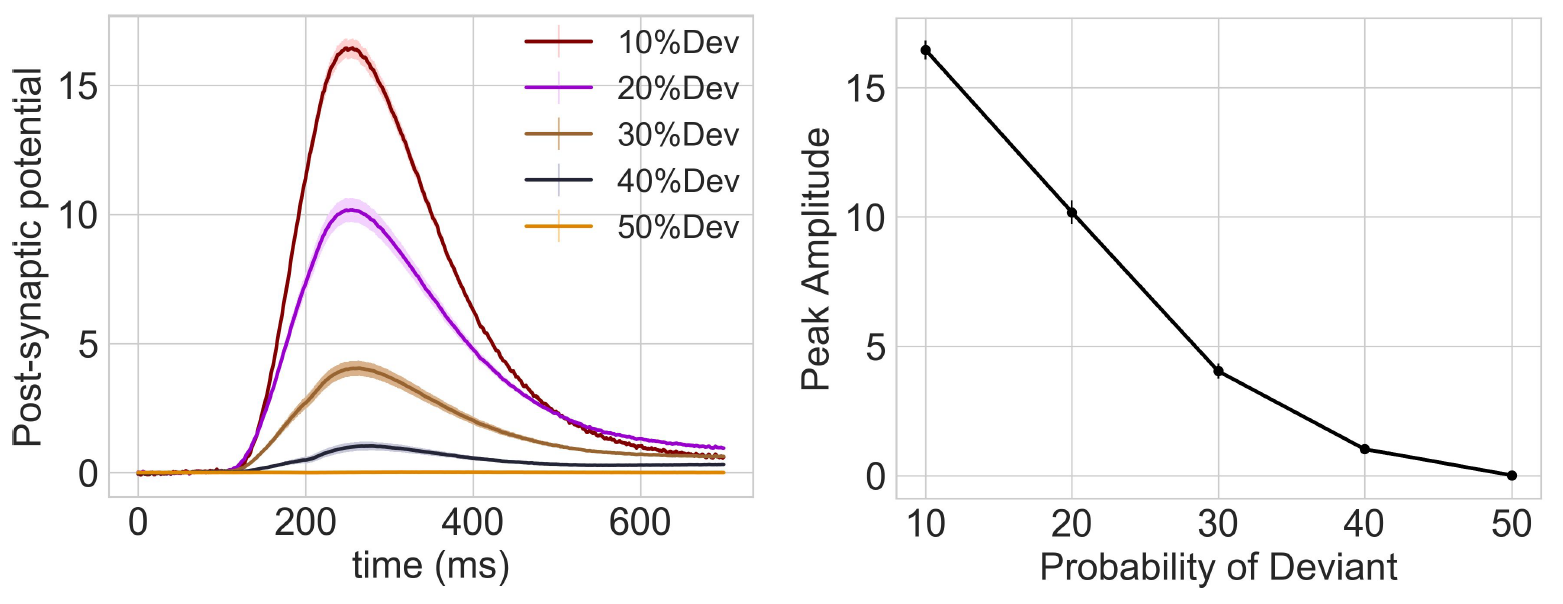

In [50]:
print "Parietal Ensemble Response"
Image(filename= path + '/probability_parietal.PNG', width=900, height=900)

### Deviance Resutls
The amount of deviance was varied by varying the intensity difference between the standard and deviant stimuli. Resutls show that as the amount of deviance increases, the MMN/P300 also increases. 

Sensory Ensemble Response


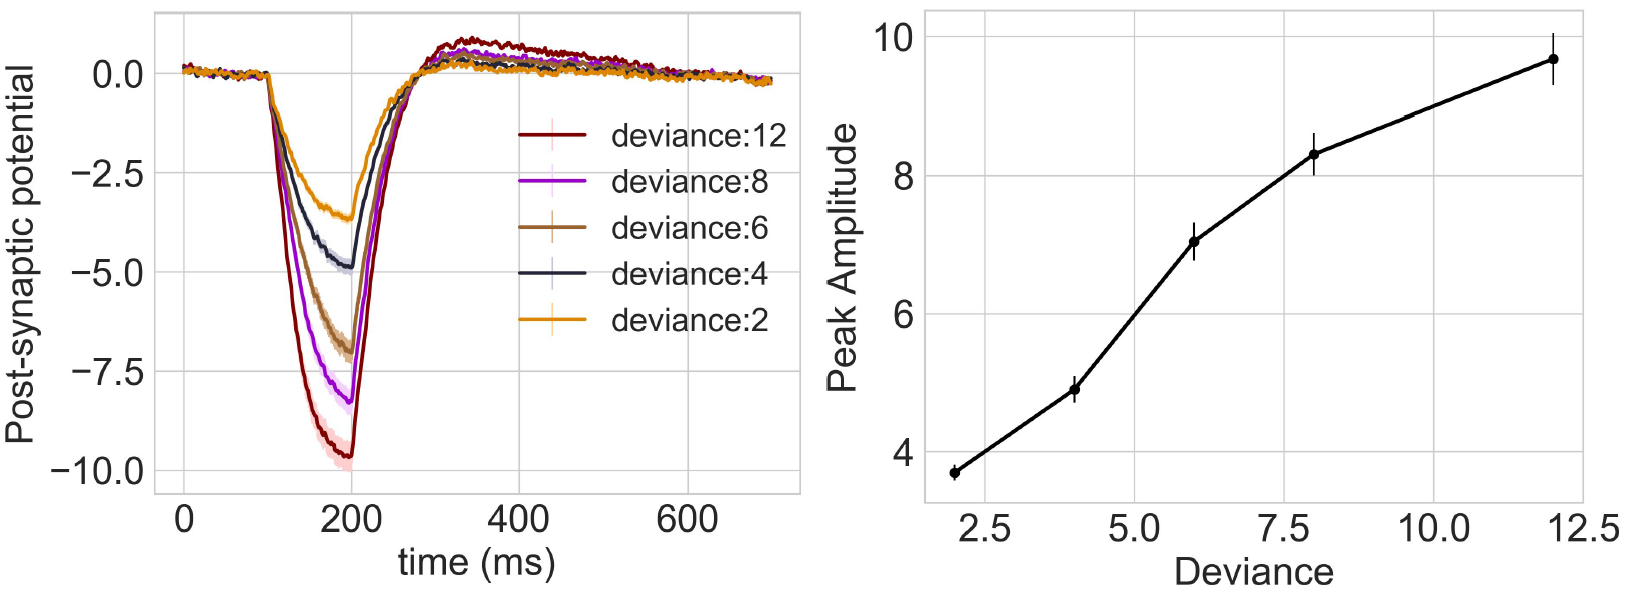

In [49]:
print "Sensory Ensemble Response"
Image(filename= path + '/deviance_sensory.PNG', width=900, height=900)

Parietal Ensemble Response


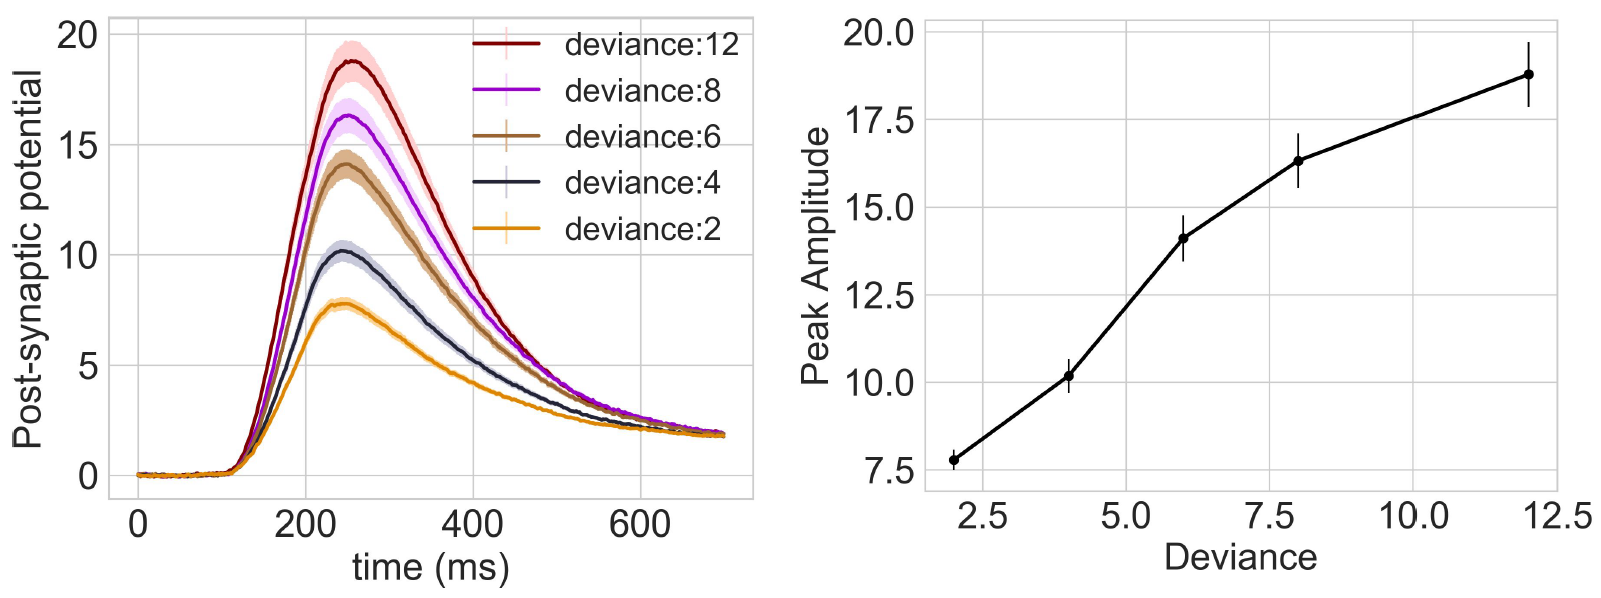

In [48]:
print "Parietal Ensemble Response"
Image(filename= path + '/deviance_parietal.PNG', width=900, height=900)

### Varying the Accumulation Parameter

The accumulation parameter (accum_wt) in the model is used to control the amount of accumulated sensory evidence that is fed-back by the recurrent connections on the $\textit{parietal}$ ensemble. We studied the effects of varying this parameter and the corresponding results show that for higher values and lower values of accumulation, P300 is not as high as it is for intermediate values of accumulation. Furthermore, accumulation of around 0.70 (70% memory of recent past) gives the best results. This shows that the memory of the recent past assists the higher level areas in generating a P300 like signal. However, having a perfect memory or too little memory degrades performance. 

Parietal Ensemble Response


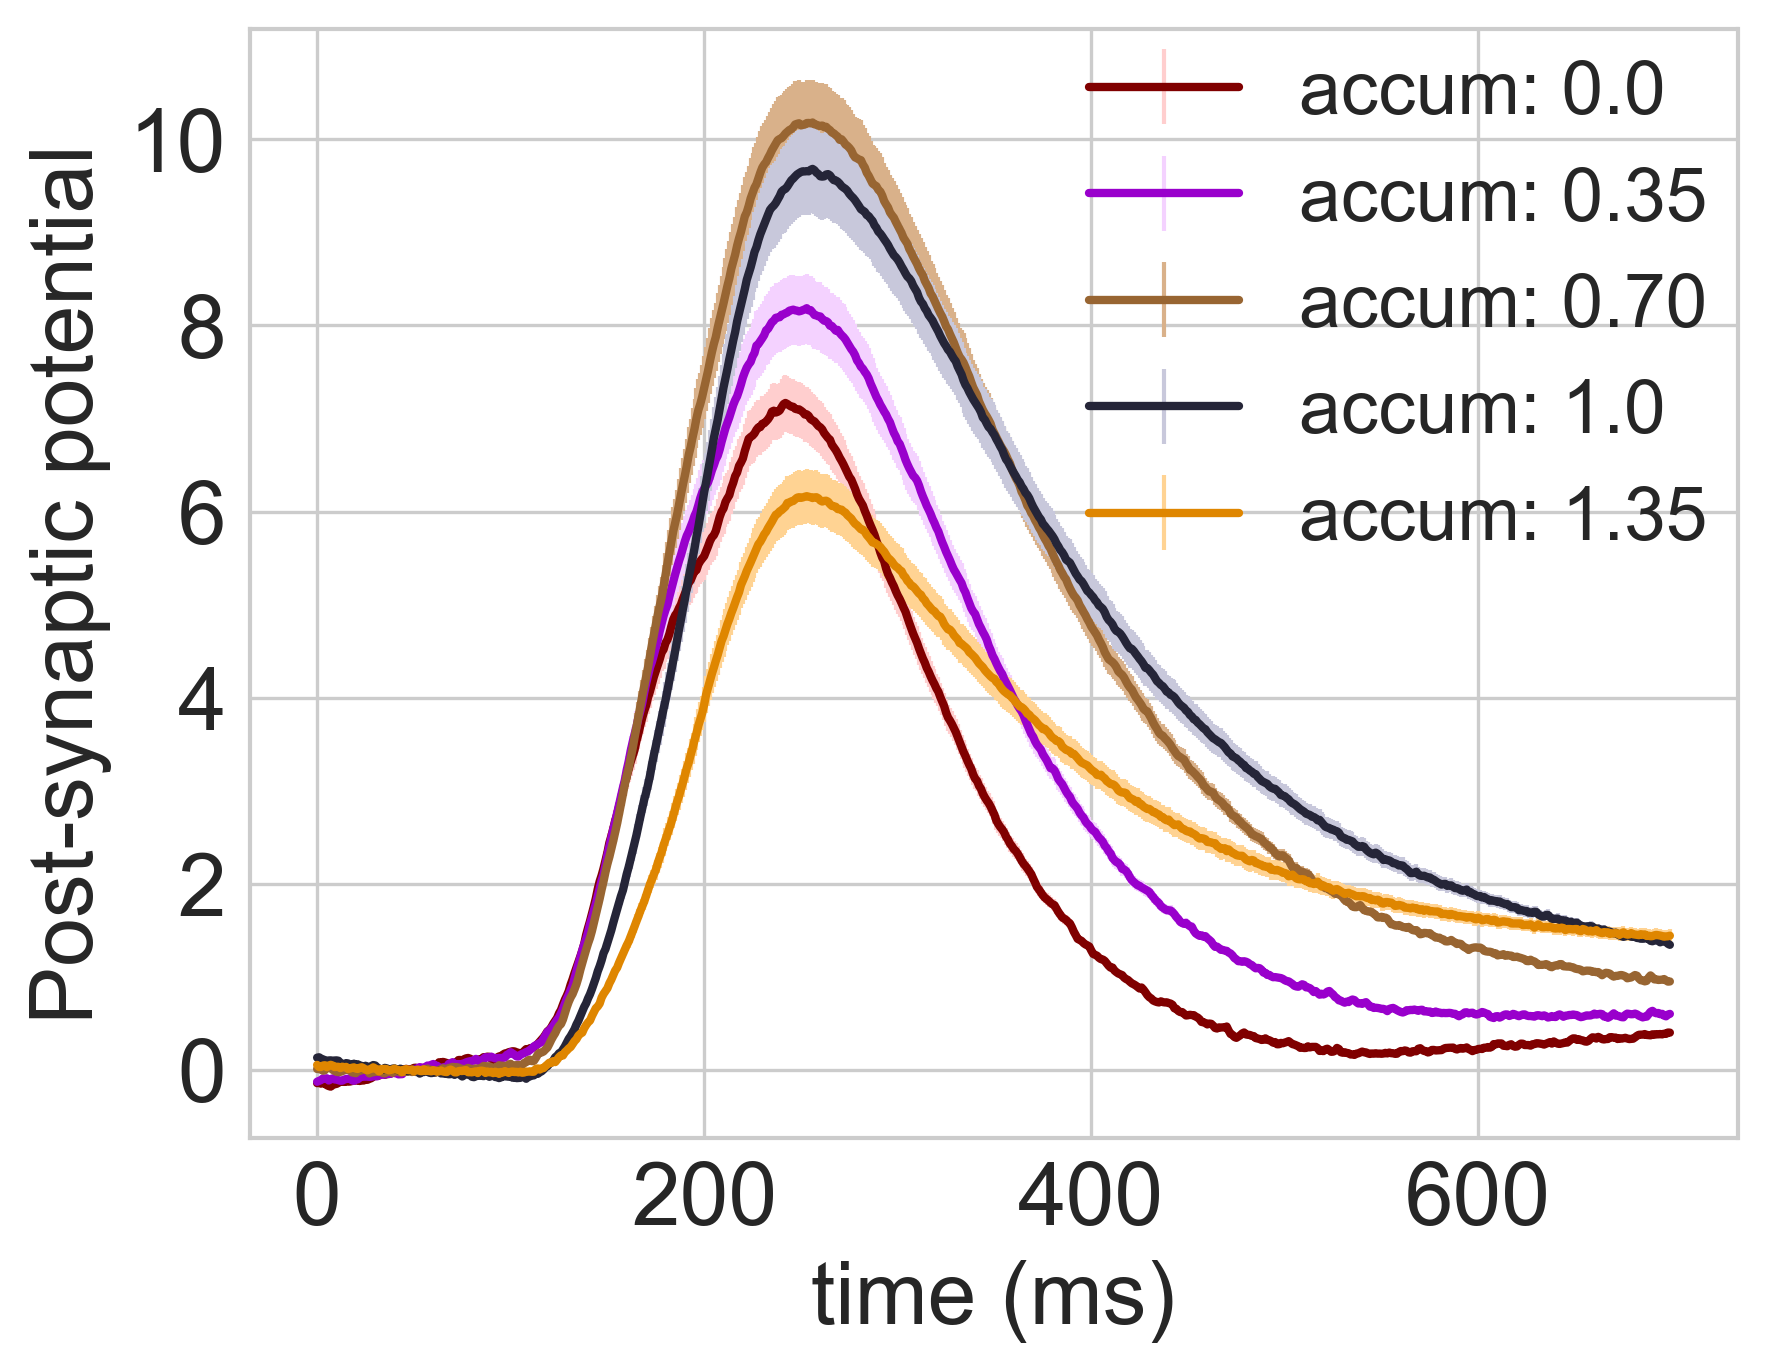

In [14]:
print "Parietal Ensemble Response"
Image(filename= path + '/accumulation.png', width=500, height=500)

### Varying Depreesing Synapse

We examined the effect of the varying the synaptic time constant of the depressing synapse $\tau$ which is used on the connection between \textit{stimulus} ensemble and \textit{sensory} ensemble. The results show that if the synaptic time constant is too short, then the neuron resources recover too quickly to extend over the time period needed to distinguish standards from deviants. In other words, there is less response depression even for the standard stimuli. The response depression is higher when the time course of synaptic recovery, $\tau$, is on the same order of magnitude as the stimulus rate (ISI). Both peak amplitude and peak latency increase as $\tau$ increases.

Sensory Ensemble Response


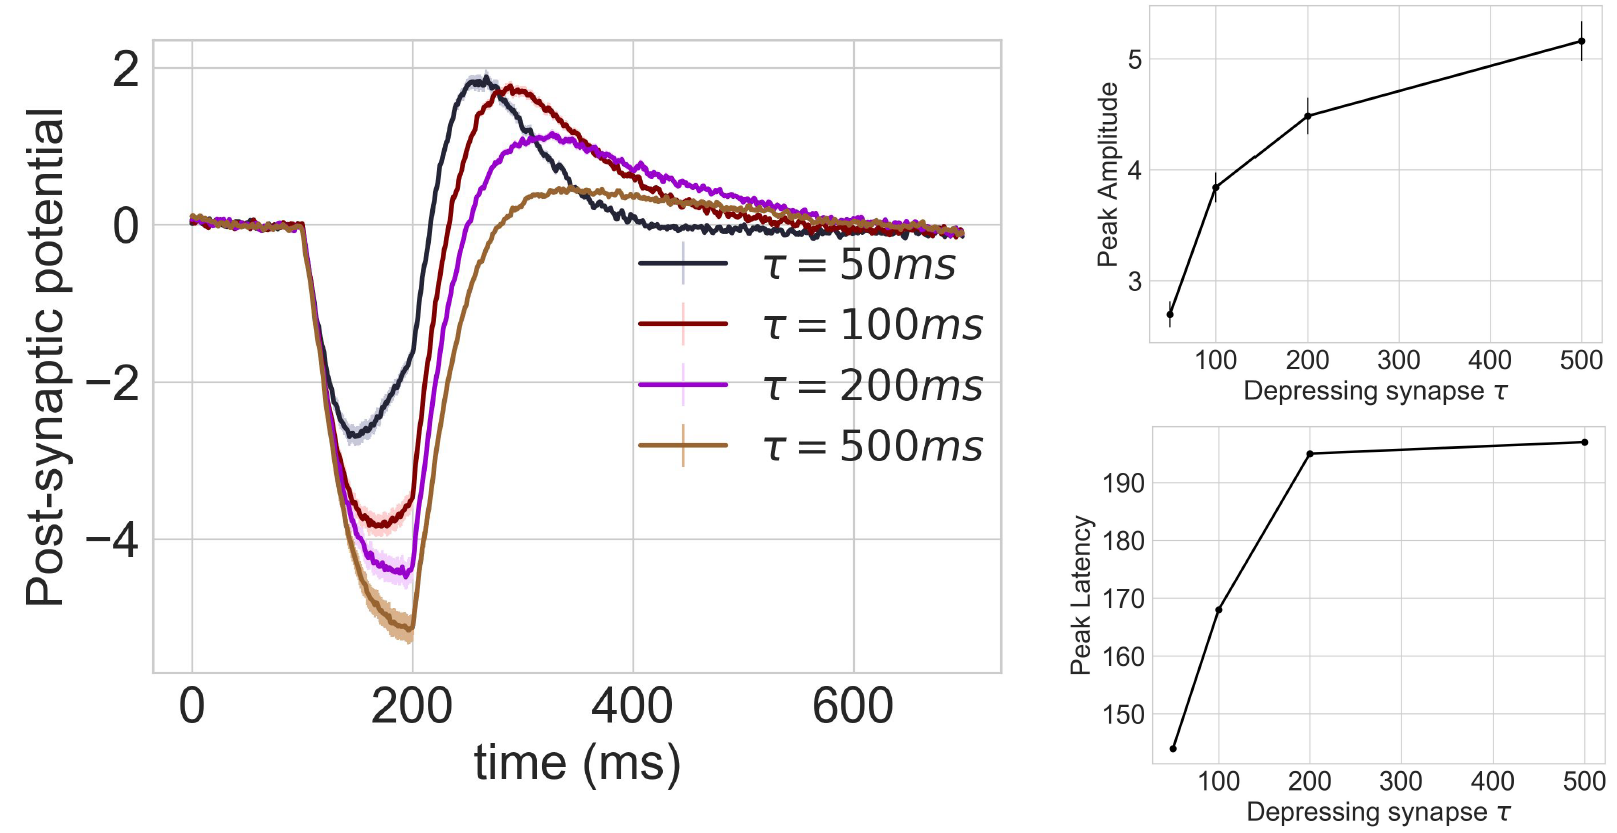

In [25]:
print "Sensory Ensemble Response"
Image(filename= path + '/tau_highpass_sensory.PNG', width=900, height=900)

Parietal Ensemble Response


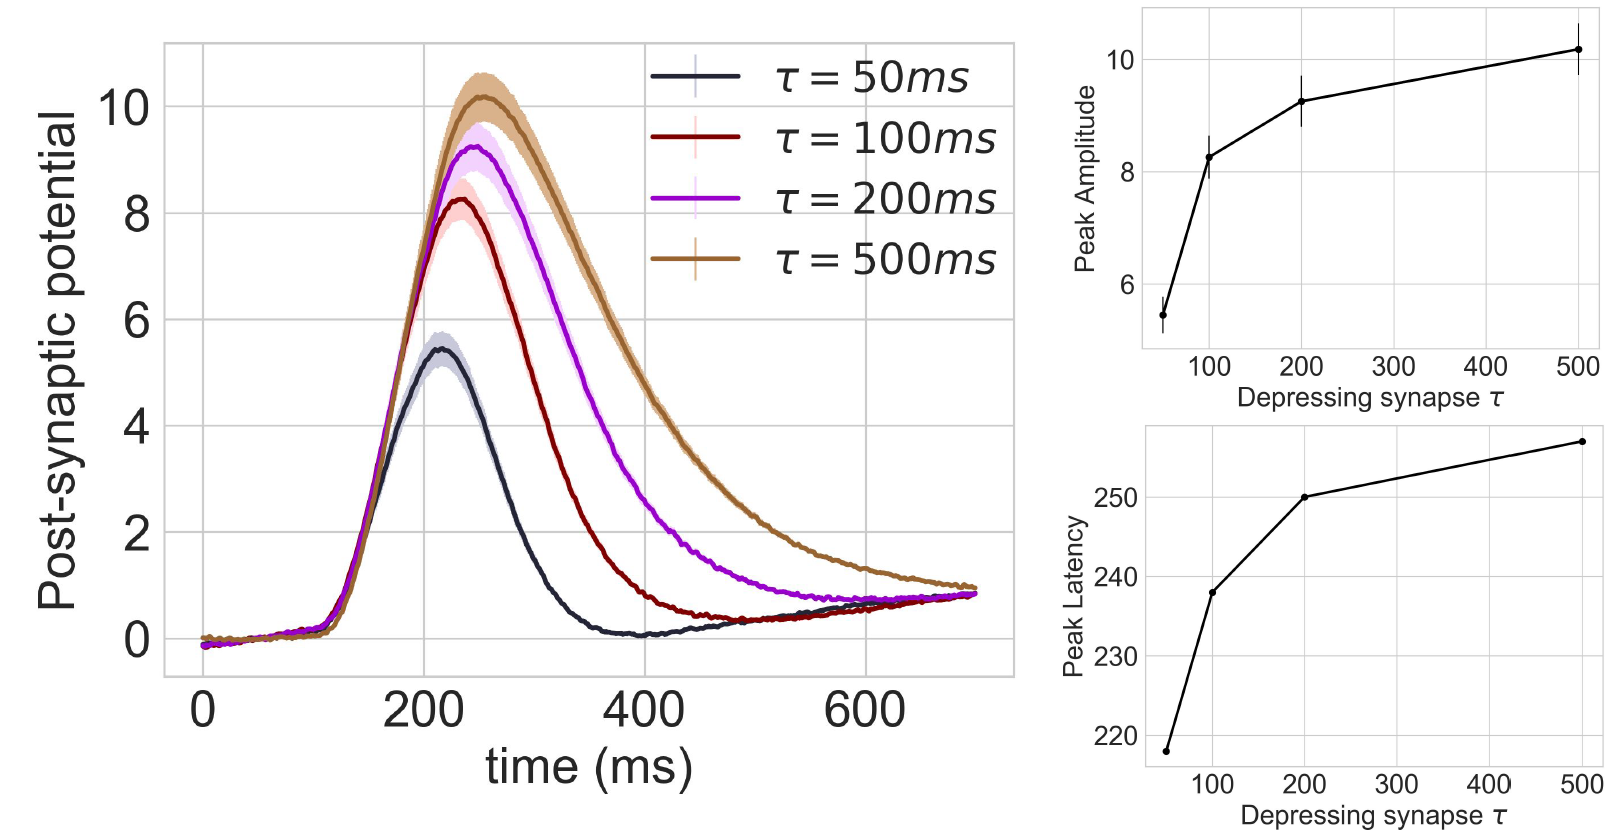

In [24]:
print "Parietal Ensemble Response"
Image(filename= path + '/tau_highpass_parietal.PNG', width=900, height=900)

### Input Stimulus Manipulations

#### Multiple Deviants

We provided to different deviants to the model to see whether its' able to distinguish between the two. The intensity of the standard was fixed at 4, the intensity of the deviant1 was fixed at 8 and that of deviant2 was fixed at 8.5. The probability of the standard, deviant1 and deviant2 was 60%, 25% and 15% respectively. The intensity of deviant1 and deviant2 was chosen to be close to minimize the effect of differential response due to neuron tuning (since neurons code for intensity). The difference in the rate of presentation captured by the probability accounted for the deviance. Since deviant2 was qualitatively more deviant than deviant1 (relative to the standard), we expected the response difference between deviant2 and standard to be greater than that between deviant1 and standard. The results were as expected and are shown below.

Sensory and Parietal Ensemble Response


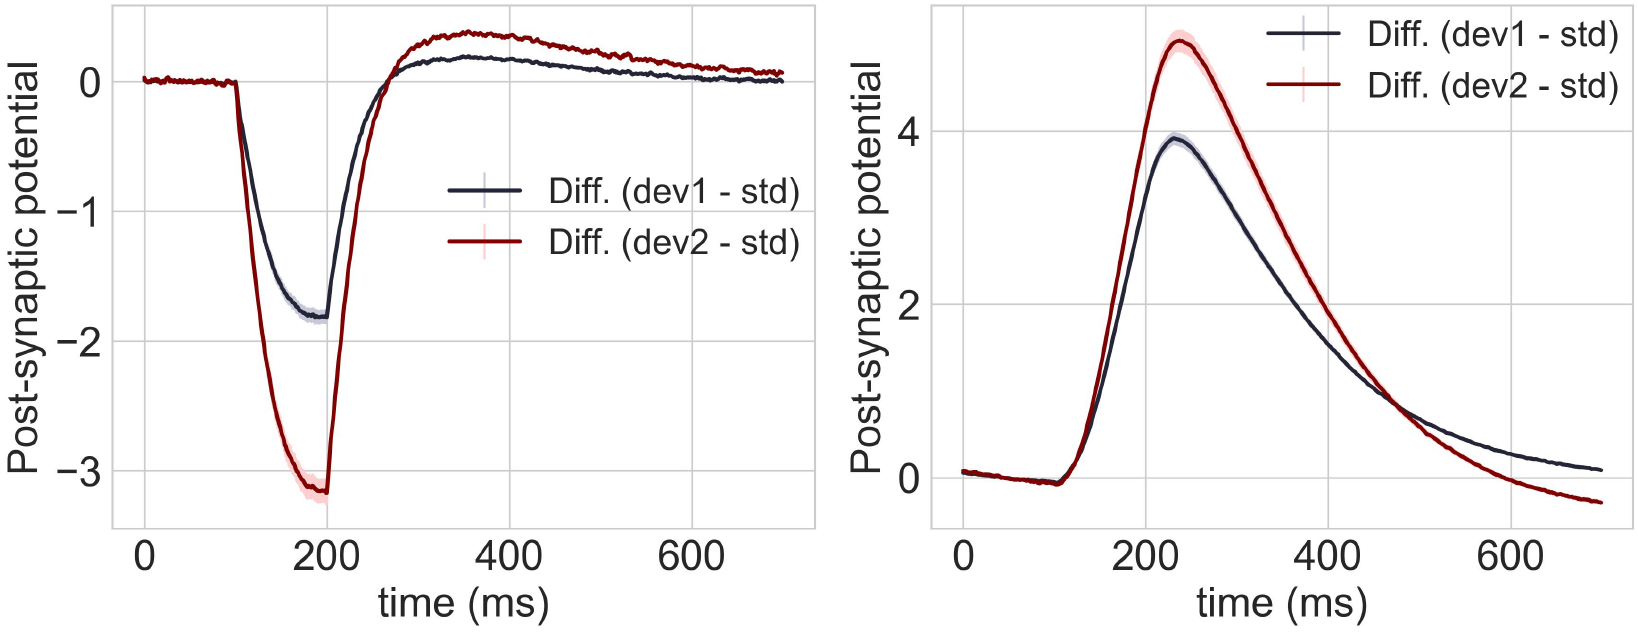

In [46]:
print "Sensory and Parietal Ensemble Response"
Image(filename= path + '/multiple_deviants.PNG', width=900, height=900)

### Regularity Encoding

We studied the effect of regularity encoding by providing the deviant embedded in a regular sequence given by AAAABAAAAB.. and so on. Note that though the probability of deviant in this case is 20%, the deviant is predictable relative to the case when the deviant is randomly presented with 20% probability. The relative response in the two cases is shown below. The local synaptic depression in the $\textit{sensory}$ ensemble shows a very little difference in the response, while the difference is more pronounced in the response of $\textit{parietal}$ ensemble. 

Sensory and Parietal Ensemble Response


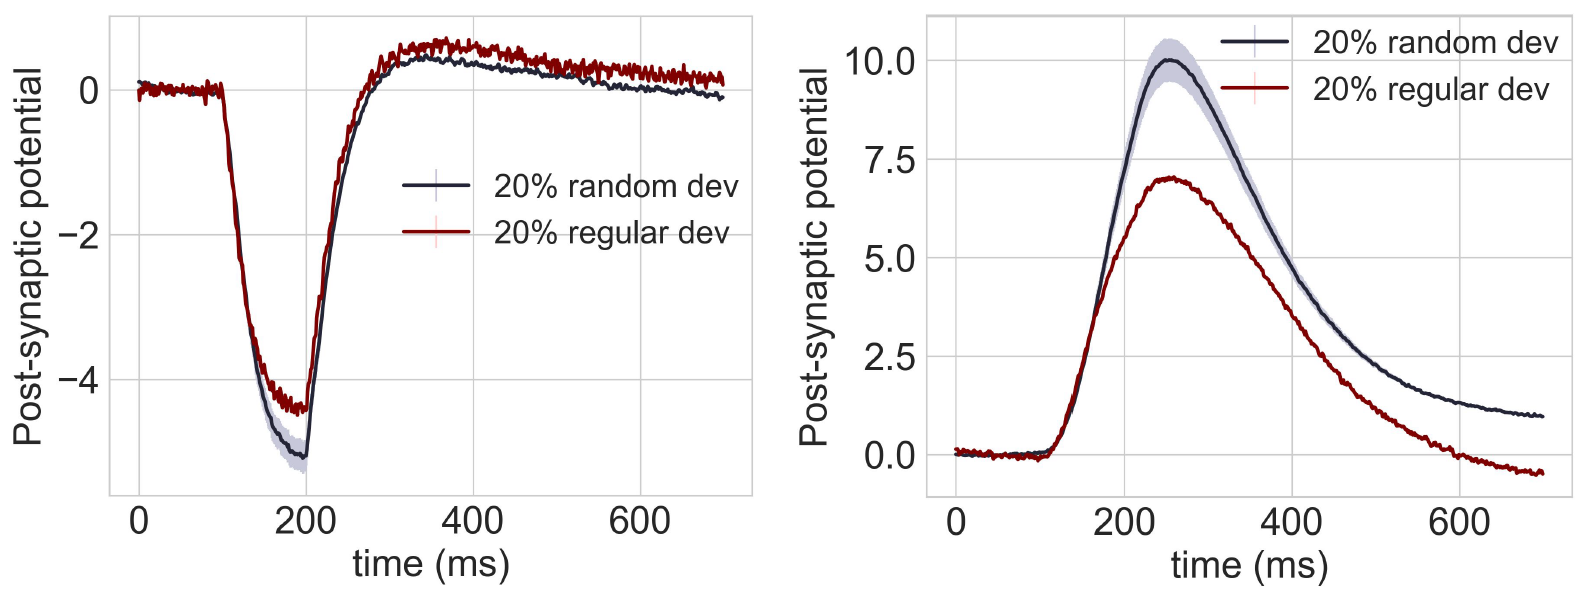

In [45]:
print "Sensory and Parietal Ensemble Response"
Image(filename= path + '/regularity_encoding.PNG', width=900, height=900)

Figures below shows the responses of these ensembles to standards and deviants separately. Though the response of the $\textit{parietal}$ ensemble to the standard is the same in both cases (random and regular deviant presentation), the response to the deviant is relatively suppressed in case of regular presentations. This is because the $\textit{parietal}$ ensemble keeps track of the stimulus history through the accumulated evidence.

Sensory and Parietal Ensemble Responses


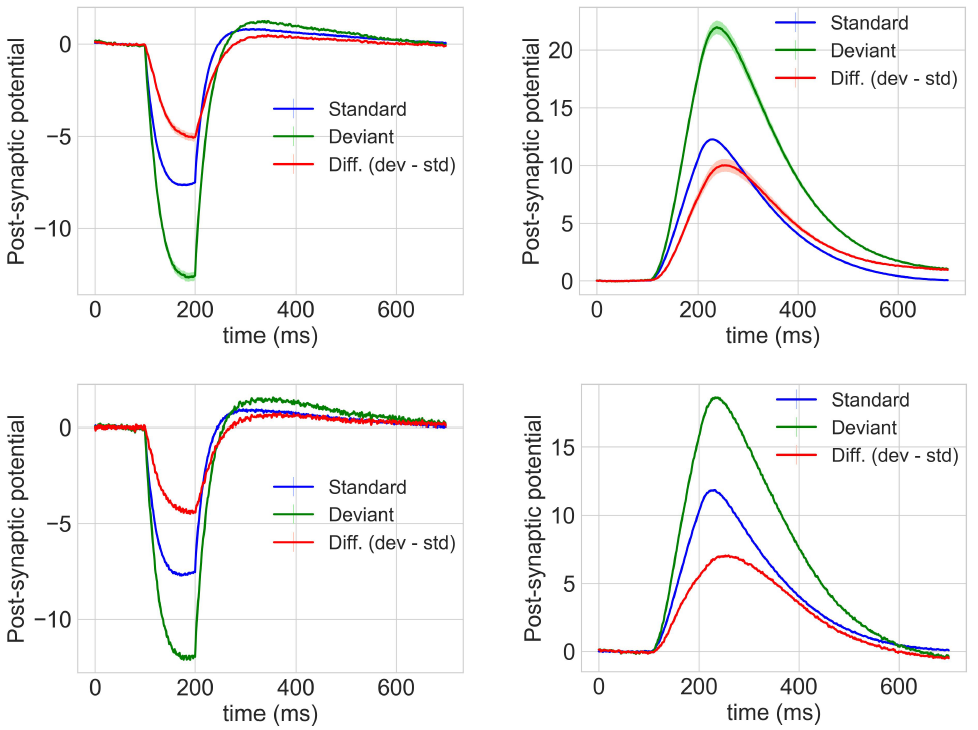

In [53]:
print "Sensory and Parietal Ensemble Responses"
Image(filename= path + '/regularity_ens_resp.PNG', width=900, height=900)

### Silent Deviant

We looked at the response of the model when only standard stimuli with intensity of 8 are presented with 80% probability and 20% trials have no stimuli presented. In other words, instead of presenting the deviants, we leave some of the trials with no stimuli (silent deviant). The results are shown below. The response to the silent deviant is still higher than that to the standard, though it is reduced. Thus the reduction in the difference is due to the lower response to silent deviant which can be attributed to the fact that the neurons are tuned to intensity of stimuli. In case of the silent deviant, the intensity is zero and hence the lower response. The response of the model in this case shows that the model treats even the absence of stimuli as deviants when it is being continuously presented with standard stimuli.

Sensory and Parietal Ensemble Response


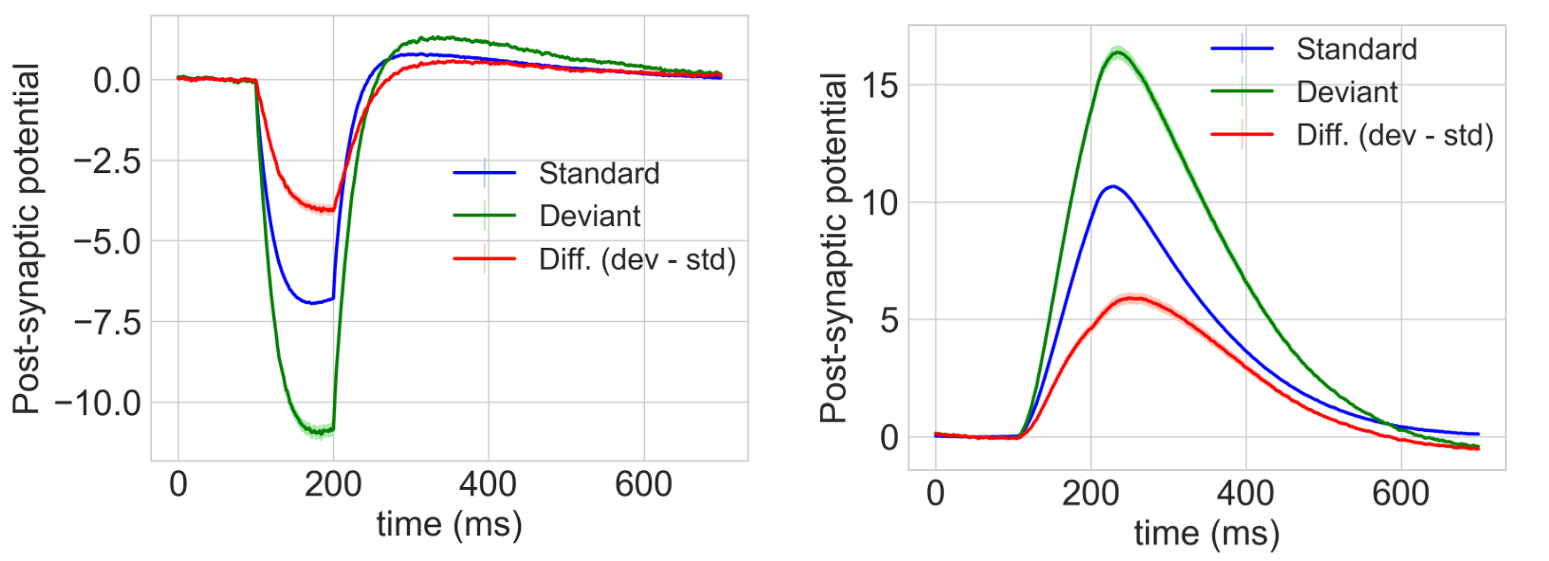

In [44]:
print "Sensory and Parietal Ensemble Response"
Image(filename= path + '/silent_deviant.PNG', width=900, height=900)

## Cascading Effects

### Cascading Effects of Depressing Synapse

Our model predicts that the higher level mechanisms that give rise to P300 are dependent on the bottom-up effects of sensory processing. To demonstrate this, we replaced the depressing synapse from the input of the $\textit{sensory}$ ensemble with a single time-constant exponential decay synapse of 10ms (same as the synapse used on all other connections in the model). The results are shown below. The response difference between the standards and deviants in this case is minimal. This difference is caused due to the Brown noise which was randomly added to the $\textit{sensory ensemble}$. On reducing the Brown noise, the difference also decreases, and goes to zero when the Brown noise is removed. Additionally we found that the accum_wt parameter that controls the evidence accumulation in the $\textit{parietal}$ ensemble has no role to play in this case as there are no statistics in the recent stimuli (no depressed responses). On setting accum_wt parameter to 0, the results shown below persist which confirms that the statistics of the recent past are not contributing to this response. 

Parietal Ensemble Response


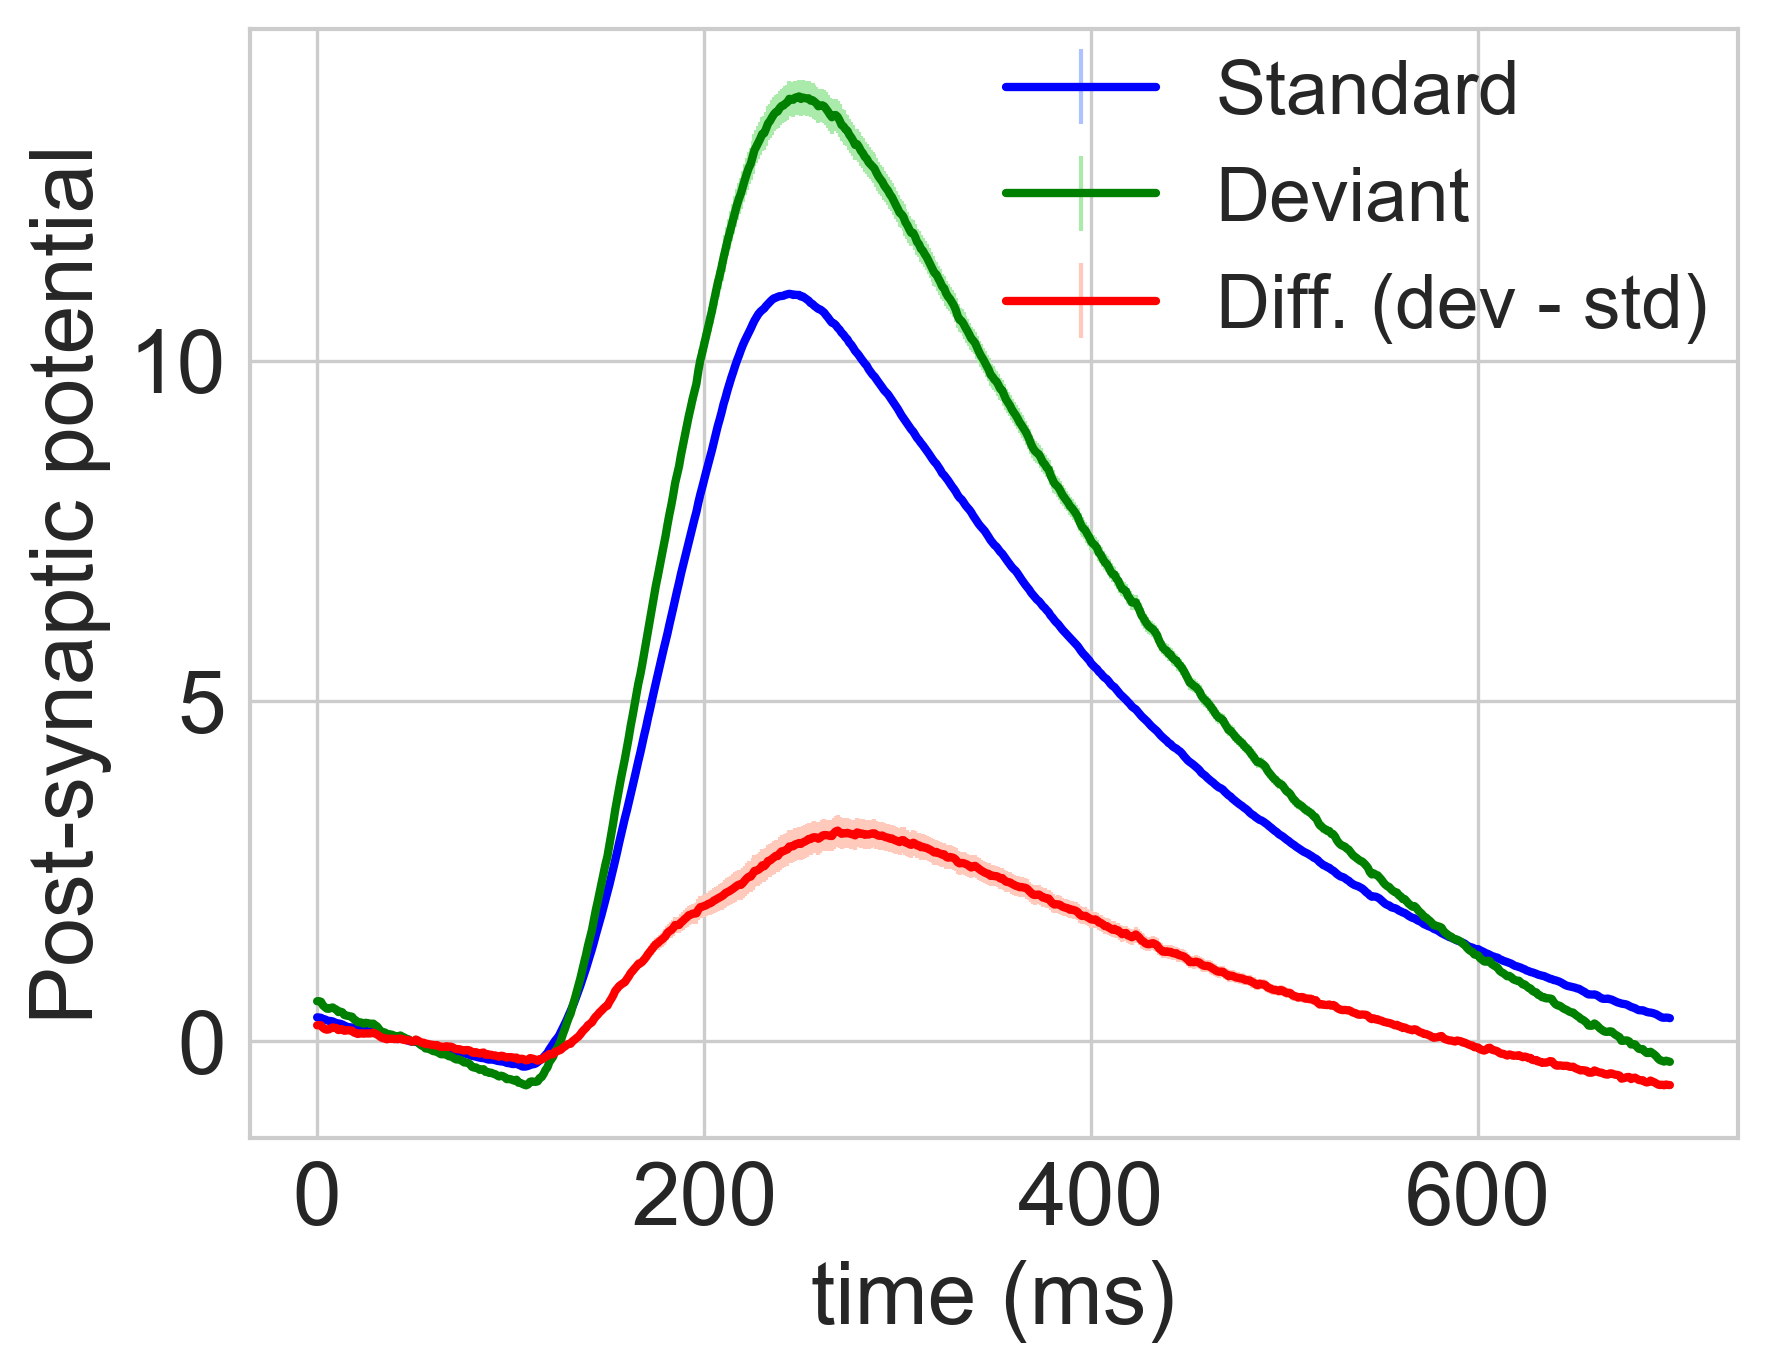

In [64]:
print "Parietal Ensemble Response"
Image(filename= path + '/no_tau_highpass.png', width=500, height=500)

### Cascading Multiple Parietal Ensembles

Here we discuss the effect of cascading multiple $\textit{parietal}$ ensembles to propose mechanisms for the generation of different ERP components. Different neural populations similar to the $\textit{parietal}$ ensemble, but with different parameters (e.g., recurrent synaptic time constant $\tau$, accum_wt, sens_wt etc.) might give rise to different ERP components in the human brain. Figure below shows how the response of the $\textit{parietal}$ ensemble varies as the recurrent synaptic time constant is varied. For values of $\tau$ less than 100ms the responses are fairly transient, however on increasing $\tau$ to 100ms and above the responses become fairly slow (slow build-up and decay). 

Parietal Ensemble Response


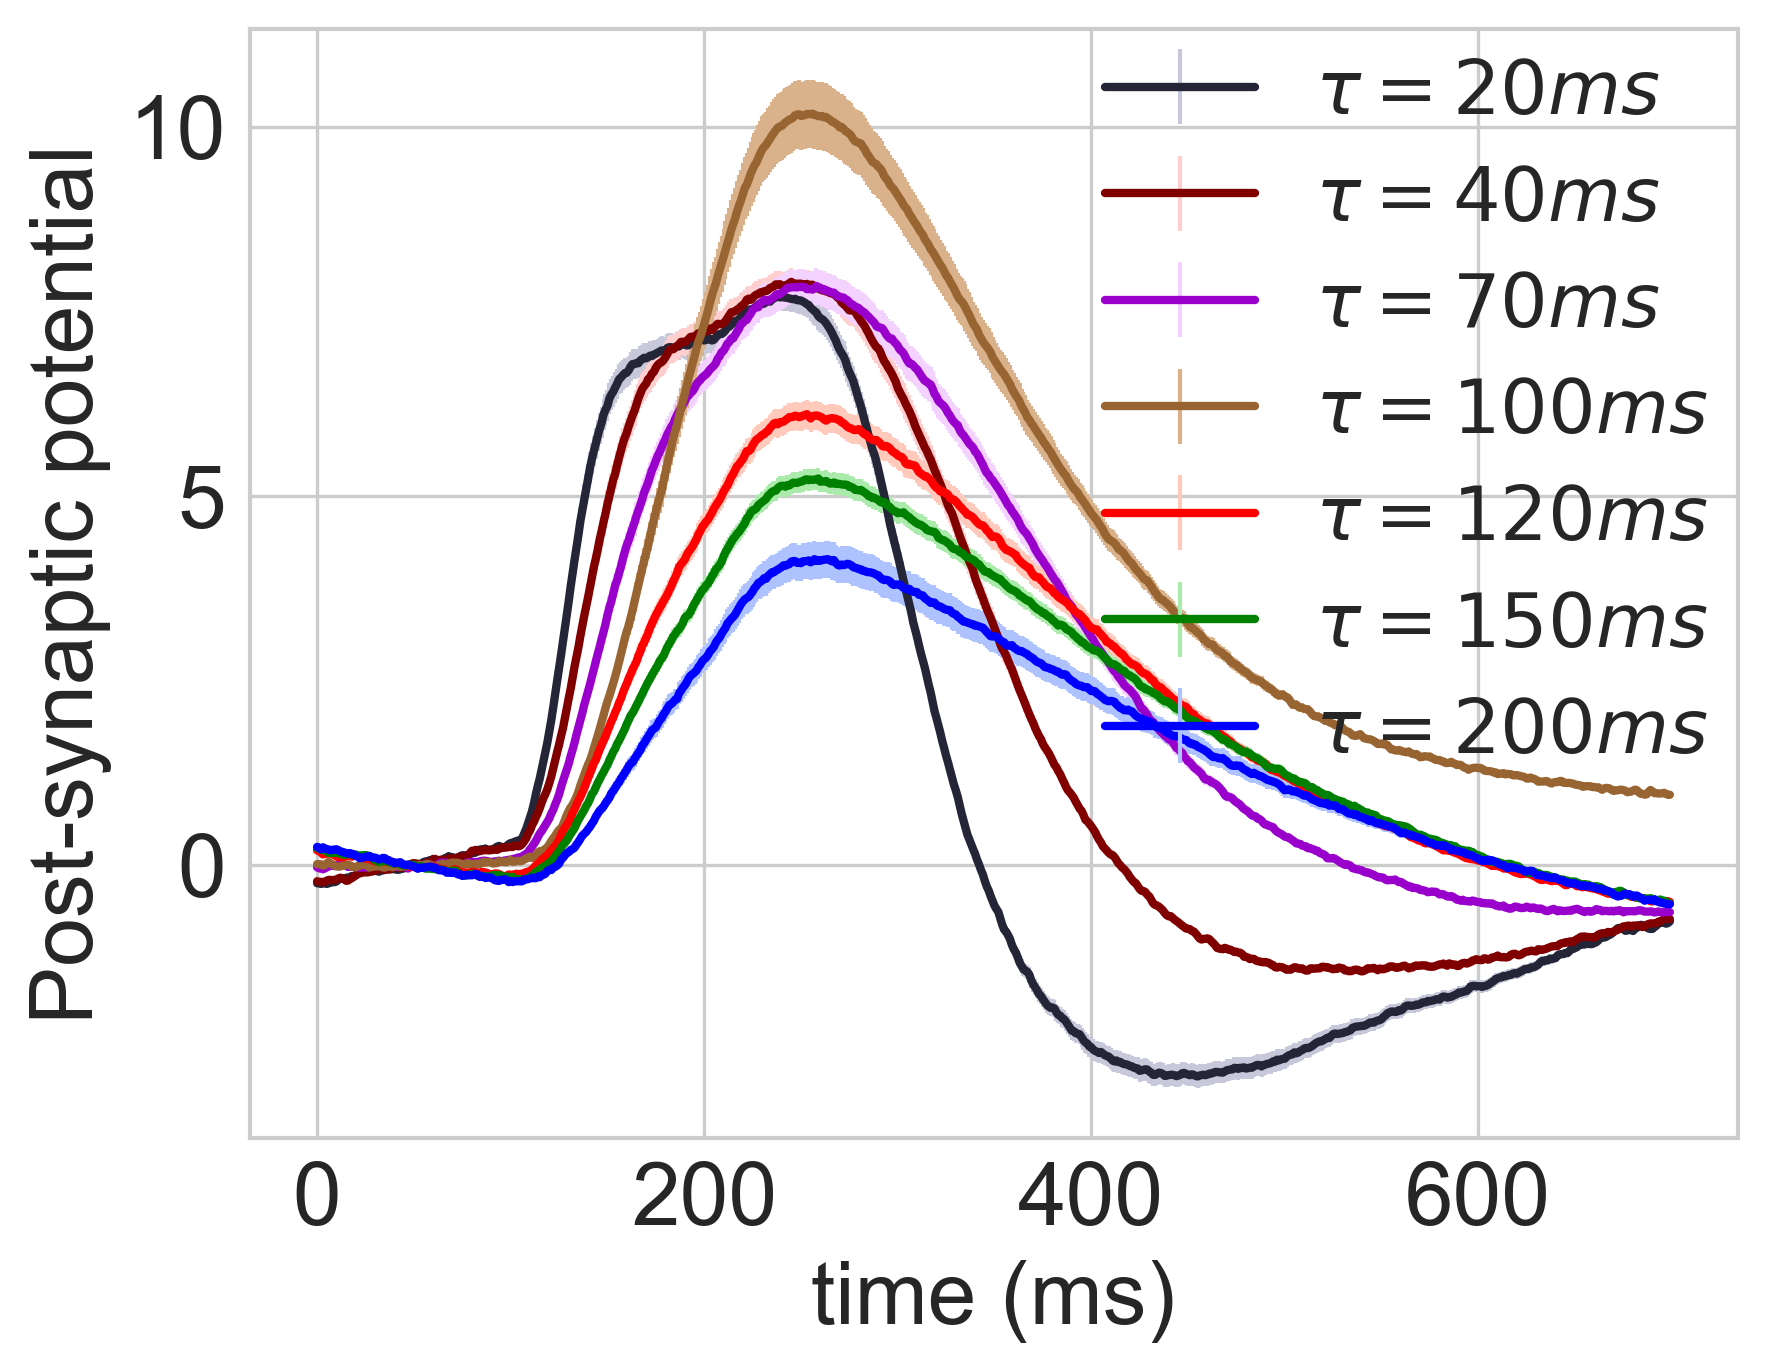

In [70]:
print "Parietal Ensemble Response"
Image(filename= path + '/recurrent_tau.png', width=500, height=500)

Additionally, we have shown before how the accumulation parameter (accum_wt) effects the response amplitude. We propose that neural populations having different values of these parameters can behave differently and might actually be the neural correlates of different ERP components. The following figure shows the response of two cascaded $\textit{parietal}$ ensembles. The first ensemble (parietal_1) gets its input from the $\textit{sensory}$ ensemble and the second ensemble (parietal_2) gets its input from parietal_1. Both ensembles have different parameters tuned to their respective response profiles i.e., P200 and P300 respectively.

Cascaded Parietal Ensembles


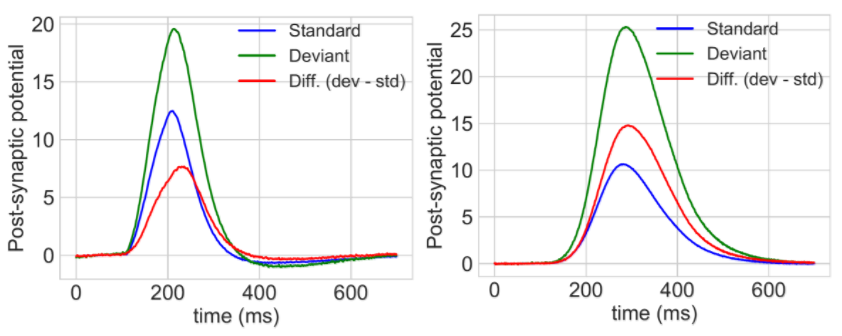

In [75]:
print "Cascaded Parietal Ensembles"
Image(filename= path + '/cascading.PNG', width=900, height=900)

## Delayed Feedback

Here we extend the network to add delayed feedback (assuming the feedback comes to a different cortical layer).

Network with delayed feedback


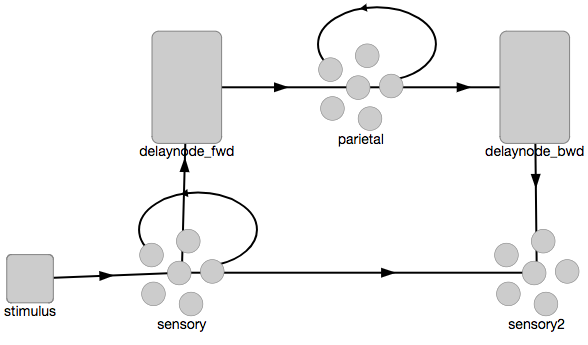

In [57]:
print "Network with delayed feedback"
Image(filename= path + '/delay_net.png', width=500, height=500)

Weighted sum of Sensory and Parietal ensemble responses


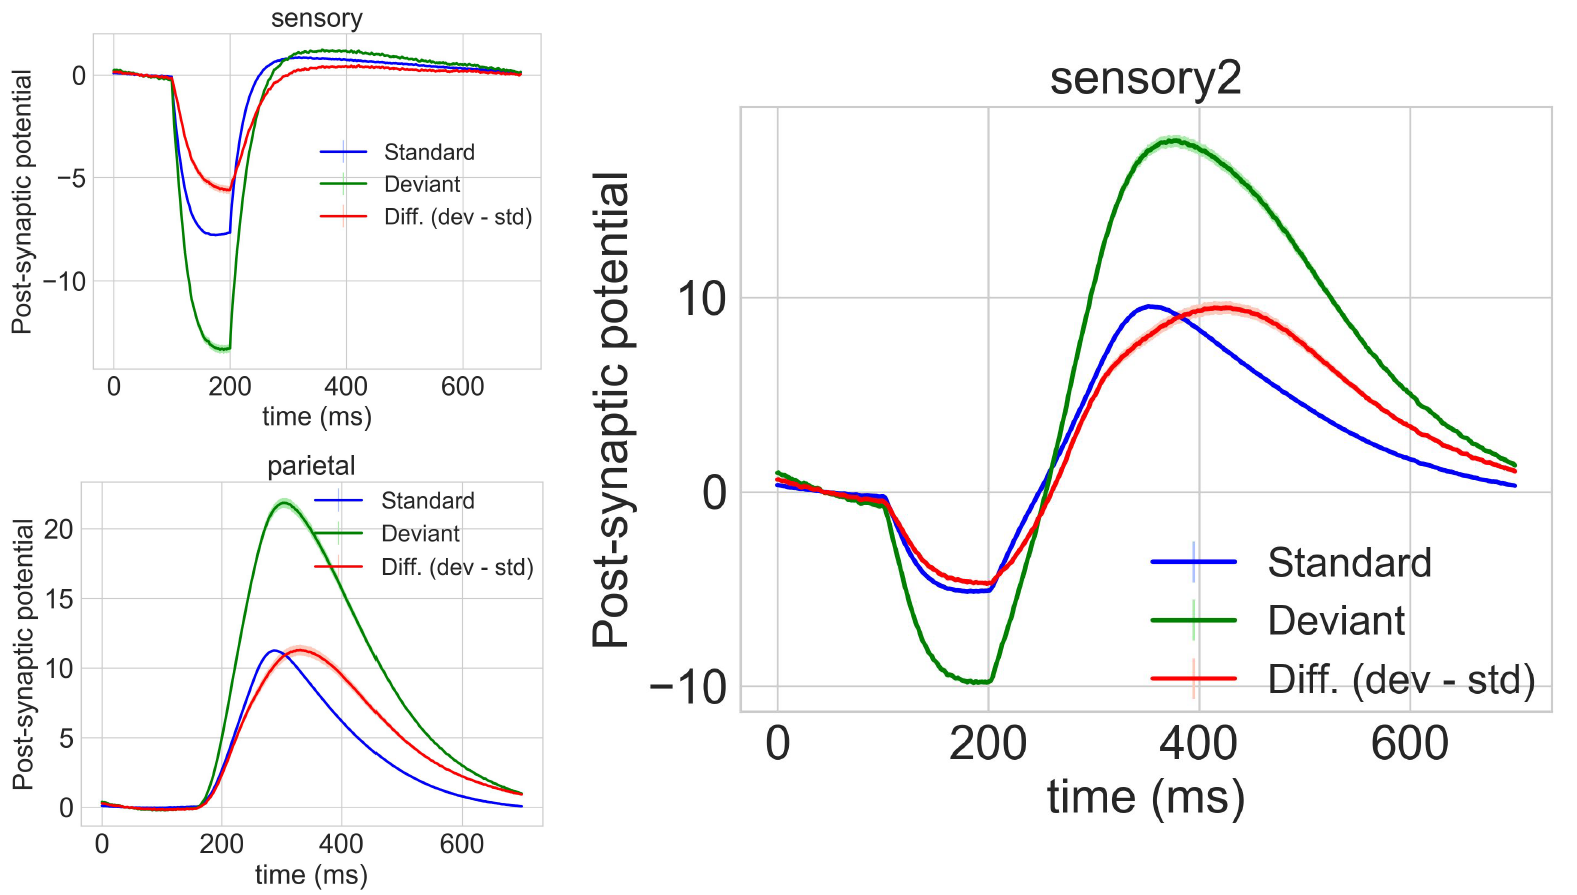

In [58]:
print "Weighted sum of Sensory and Parietal ensemble responses"
Image(filename= path + '/delay_fdbck.PNG', width=900, height=900)